# A/B Testing with T-Test

This dataset comes from https://www.kaggle.com/datasets/farhadzeynalli/online-advertising-effectiveness-study-ab-testing
The exploratory analysis can be found in the AB_Test_EDA.ipynb file

**Background**
A large company with a substantial user base plans to increase sales through advertisement on its website. However, they are undecided about whether the ads increase sales or not. In order to determine whether this is the case, 20,000 customers were subjected to A/B testing for 31 days. 

Each customer was assigned a unique identifier, and the groups were split in a 60:40 ratio, with the larger group seeing the new advertisement and the smaller group seeing a public service announcement (psa) in its place. The outcome measured was whether the client made a purchase, delivered as a boolean statement. Additional parameters and metrics collected included the day of the month the user saw the most ads, the hour of the day the user saw the most oads, and the total number of ads seen by each user. 

The company has contracted the analysis out with the above information. 

**Follow-up**
The analysis prompt of whether to run the ad was poorly-defined, so the following questions were posed to the project manager: 
*Critical Questions*
1. Is the PSA currently running, or is this also a new addition to the campaign? 
    *I need to know whether this is truly a control group, or if we're testing two new products compared to one another.* 
2. What is your current conversion rate? 
3. What is the minimum percentage increase in conversion that you would need to take action on moving forward with the campaign?
    *This would be critical prior to collecting the data to ensure enough people were sampled, but at this point, we can only verify that we have enough to identify this with an appropriate confidence level*  

*Additional Questions*
4. Are you looking at insight into which day or days of the week to run the campaign, or is this irrelevant?
    If so, what month-year was the 31-day test performed? 
5. Are you trying to target a certain demographic to boost sales during certain times of day?
6. Do you want to know how many ads may yield different results? 
    *In other words, we are reframing the question of whether ads drive conversion to how many ads are needed to increase conversion if at all.* 


**Responses**
1. Since this is run on the company's own website, the PSA is currently a placeholder sale prices of certain products. It is in the same format as the rest of the webpage, and doesn't particularly stand out. The new ad would replace the PSA, showing a featured product linking to a page with sale prices. 
    *The PSA is truly a control group*
2. The metrics I've been provided suggest the current conversion is around 3 or 4 percent. We're really hoping to bump it up to 7 or 8 percent. 
3. We'd like to see a 3% to 4% increase in sales, but we'll continue with the ad campaign with at least a 2% increase. 
4. Right now we're running the ad on our own website, but we'd like to see metrics on that for potential ad campaigns on different sites.
6. Yes - what we would like to see is if the number of times the client visited the website correlates with purchases, so what we would like to know is 
    Was the number of visits on the page with either format correlated with conversion? 
    Was the number of visits on the page with the PSA correlated with conversion? 
    Was the number of visits on the page with the Ad correlated with conversion? 
    Is there a difference between the number of visits with the PSA and number of visits with the Ad? 


---
## Analytical Preparation
We can define the control and treatment groups for the study as the PSA and ad, respectively. It's also important to define the metric that we are comparing, and here is is the conversion rate. Since the conversion rate is a quantitative measure, a T-Test is an appropriate statistical test to evaluate whether there was a significant difference between the means of the control and treatment, and since there is the potential for the treatment to have either an increased or decreased mean with respect to the control, a Two-Tailed T-Test is the more appropriate. 

H<sub>o</sub>:  Null Hypothesis 
H<sub>a</sub>:  Alternative Hypothesis
p:              Control Group Conversion Rate (PSA)
p<sub>o</sub>:  Treatment Group Conversion Rate (Ad)

**Null Hypothesis**

H<sub>o</sub>: p = p<sub>o</sub>
There will be no difference between the conversion rates of the control (PSA) and the treamtent (Ad)

**Alternative Hypothesis**

H<sub>a</sub>: p $\not=$ p<sub>o</sub>
There will be a significant difference between the conversion rates of the control (PSA) and the treament (Ad)

**Significance and Power**

$\alpha$ = 0.05
$\beta$ = 0.80

Per convention, $\alpha$ was set to 5%, giving the probability of a Type I Error (false positive). A value is considered significantly different if and only if the p-value is under $\alpha$, reducing the chance of the finding of being a false positive to under 5%. 
Also per convention, $\beta$ was set to 80%, giving the probability of a Type II Error (false Negative). This is used in determining the likelihood of testing a true effect if there is one. This will be used in the power analysis to verify that the minimum sample size required to achieve the desired significance level, effect size, and statistical power. 

---
## Experimental Preparation

Typically, a Power Analysis is done prior to implementing a study and collecting survey information. The client has already implemented and collected survey data, and they have not provided us with an exact current conversion rate. What we will need to calculate for this analysis includes the effect size, statistical power, alpha, and the ratio of the number of values in the treatment group to those in the control group. For this we will go with the low end of their predicted existing conversion rate of 3%, and the minumum change in the range of 2%, ending with a 5% outcome. The smaller the difference between the two means, the more observations must be collected to be confident of a true difference between means not due to random sampling error.  

In [31]:
# Dependencies
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'weight': 'bold',
        'size': 16}

mpl.rc('font', **font)

random_state = 621

## Power Analysis

In [24]:
effect_size = sms.proportion_effectsize(0.03, 0.05)
effect_size

-0.10286079052330155

In [25]:
required_observations = sms.NormalIndPower().solve_power(
    effect_size, 
    power = 0.8, 
    alpha = 0.05, 
    ratio=1.5  # This provides the ratio of the number values in sample 2 to those in sample 1. The 40:60 ratio would be 1.5, as 60 is 1.5 times the control 
)

# ceil is the ceiling function; it rounds up to the next whole number
required_observations = ceil(required_observations)
print(f'There are {required_observations} observations in each group to be 80% confident that there is a 2% difference between the two groups.')


There are 1237 observations in each group to be 80% confident that there is a 2% difference between the two groups.


Since the smaller of our groups has nearly 8000 observations, we have more than enough data to work with in assessing this kind of change. 

---
## Data Exploration
During the Exploratory Data Analysis, the following were considered: 
- Length of table
- Presence of duplicates
- Number of observations per test group
- Presence of Null values
- Number of dependent variable results
- Distribution of Days
- Distribution of Hours
- Distribution of Ad Count
 

In [26]:
ab = pd.read_csv('online_ad_AB.csv')
ab.head()

,customerID,test group,made_purchase,days_with_most_add,peak ad hours,ad_count
0,1,ad,False,24,20,5
1,2,psa,False,21,16,9
2,3,psa,False,1,18,8
3,4,ad,False,20,23,7
4,5,ad,False,3,13,5


In [27]:
length = len(ab)
dupes = ab.duplicated().value_counts()
groups = ab['test group'].value_counts()
nulls = ab.isnull().sum().sum() # The first sum quantifies the sum of nulls per column, the second sum adds all sums from the column sums
purchased = ab['made_purchase'].value_counts()

print(f'The dataframe has {length} rows. The number of duplicate rows is {length - dupes[0]}.')
print(f'We expected to see a 40:60 ratio of PSA:Ad observations. The actual distribution is {groups[1]} PSAs to {groups[0]} Ads, which is not exacly a 40:60 ratio, but close.')
print(f'The number of nulls across all columns and rows was {nulls}. There were {purchased[1]} clients that purchased the product and {purchased[0]} that did not.')


The dataframe has 20000 rows. The number of duplicate rows is 0.
We expected to see a 40:60 ratio of PSA:Ad observations. The actual distribution is 7947 PSAs to 12053 Ads, which is not exacly a 40:60 ratio, but close.
The number of nulls across all columns and rows was 0. There were 1060 clients that purchased the product and 18940 that did not.


Text(0.5, 0, 'Day of the Month')

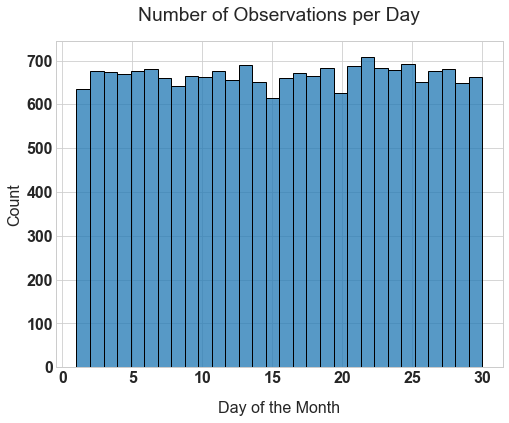

In [43]:
plt.figure(figsize=(8, 6))

sns.histplot(data=ab['days_with_most_add'], bins=30)
plt.title('Number of Observations per Day', pad=20)
plt.xlabel('Day of the Month', labelpad=15)


In [64]:
counts = ab['days_with_most_add'].value_counts()

print(f'The minimum number of site visits on any given day was {min(counts)}, and the maximum was {max(counts)}. The distribution looks mostly uniform, without any patterns to suggest visits were higher on weekends or weekdays.')

The minimum number of site visits on any given day was 614, and the maximum was 709. The distribution looks mostly uniform, without any patterns to suggest visits were higher on weekends or weekdays.


Text(0.5, 0, 'Group')

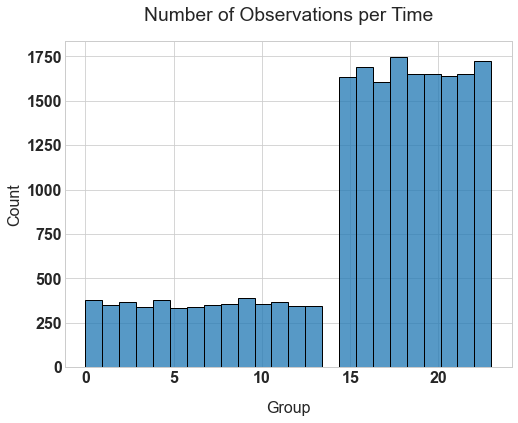

In [49]:
plt.figure(figsize=(8, 6))

sns.histplot(data=ab['peak ad hours'], bins=24)
plt.title('Number of Observations per Time', pad=20)
plt.xlabel('Group', labelpad=15)


The hours of the day information revealed a few interesting things: 
1. No ads or psas were seen between 2 and 3 pm. 
2. The number of visits from 3 pm through 11 pm were over 5 times of the number of visits between midnight and 2 pm 

This gives some insight as to the time for exposure, though this does not show the difference between the PSAs run and the Ads run at those hours, only that there was elevated traffic in the afternoon and evening. 

Text(0.5, 0, 'Number of Page Visits')

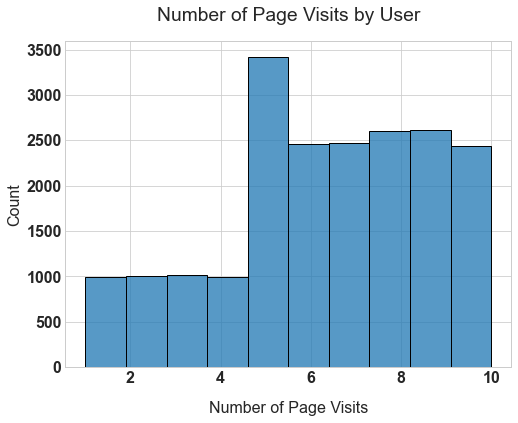

In [54]:
plt.figure(figsize=(8, 6))

sns.histplot(data=ab['ad_count'], bins=10)
plt.title('Number of Page Visits by User', pad=20)
plt.xlabel('Number of Page Visits', labelpad=15)


Above we see that the highest number of users saw the page 5 times, most users looked at the landing page 5 or more times. Again, this hasn't started considering the number of users who have seen the ad versus psa or whether they made a purchase. The range of these data show that all users have seen the landing page at least once, and no one visited the landing page more than 10 times. 

---
## Data Cleaning
The data provided here are already very clean. The only thing that has been particularly annoying has been the lack of convention in the naming, with some of the names using an underscore and others with spaces. This can easily be fixed with a dictionary.

In [65]:
ab.columns

Index(['customerID', 'test group', 'made_purchase', 'days_with_most_add',
       'peak ad hours', 'ad_count'],
      dtype='object')

In [66]:
new_columns = {
    'customerID': 'customer_ID', 
    'test group': 'test_group',
    'made_purchase': 'converted', 
    'days_with_most_add': 'impressions_by_date',
    'peak ad hours': 'impressions_by_time',
    'ad_count': 'impressions_per_visit'}

ab.rename(columns=new_columns, inplace=True)
ab.head()

,customer_ID,test_group,converted,impressions_by_date,impressions_by_time,impressions_per_visit
0,1,ad,False,24,20,5
1,2,psa,False,21,16,9
2,3,psa,False,1,18,8
3,4,ad,False,20,23,7
4,5,ad,False,3,13,5


Now that the data is cleaned and has appropriate naming for the columns, we will continue to the the Analysis. 

---
## Analysis
At this moment, we only have the raw data, but our hypotheses are investigating the conversion rates. To do this, we need to find how many of the users were converted per group. 

In [70]:
# Define functions for standard deviation and standard error to apply when creating a table
# Std. deviation of the proportion
def std_p(x): return np.std(x)
# Std. error of the proportion (std / sqrt(n))
def se_p(x): return stats.sem(x)
def mean(x): return np.mean(x)

conversion_rates = ab.groupby('test_group')['converted']
conversion_rates = conversion_rates.agg([mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')


,conversion_rate,std_deviation,std_error
test_group,,,
ad,0.067,0.249,0.002
psa,0.032,0.177,0.002


Text(0, 0.5, 'Conversion Rate')

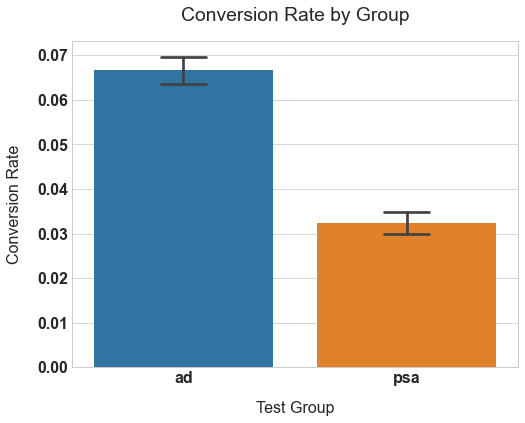

In [85]:
plt.figure(figsize=(8, 6))

sns.barplot(data=ab, x='test_group', y='converted', estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Group', pad=20)
plt.xlabel('Test Group', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)

The above graph shows the Conversion Rate by group, where the PSA is our control group and the ad is our treatment group. The error bars show the confidence interval set to 80%, as we established in our experimental design. The standard deviations in the table are over 4 times greater than the mean itself, and graphically, this will look awful. The next step is to determine significance with the T-Test. 
Well, sort of. Since the N is substantially higher than 100, I'll actually be using a Z-test, as the T-Test and the Z-Test are effectively the same when N > 100. So in obtaining our p-value, I will be using the proportions Z-test and confidence interval. 


In [97]:
# Separate the results sets
control_results = ab[ab['test_group'] == 'psa']['converted'] 
treatment_results = ab[ab['test_group'] == 'ad']['converted']

# Count subtotals
n_control = control_results.count()
n_treatment = treatment_results.count()
conversions = [control_results.sum(), treatment_results.sum()]
n_observations = [n_control, n_treatment]

z_stat, pval = proportions_ztest(conversions, nobs = n_observations) # Proportion Z-Test
(lower_control, lower_treatment), (upper_control, upper_treatment) = proportion_confint(conversions, nobs=n_observations, alpha = 0.05) # Proportion Confidence Interval

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.28f}')
print(f'ci 95% for control group: [{lower_control:.3f}, {upper_control:.3f}]')
print(f'ci 95% for treatment group: [{lower_treatment:.3f}, {upper_treatment:.3f}]')


z statistic: -10.59
p-value: 0.0000000000000000000000000331
ci 95% for control group: [0.028, 0.036]
ci 95% for treatment group: [0.062, 0.071]


In [118]:
minimum_difference = (lower_treatment - upper_control)*100
maximum_difference = (upper_treatment - lower_control)*100
psa_mean = conversions[0]/n_control
ad_mean = conversions[1]/n_treatment
mean_difference = (ad_mean-psa_mean)*100

print(
    f'The range of percent increase with the ad spans from the minumum of {minimum_difference:.2f}% to a maximum of {maximum_difference:.2f}% within the confidence interval of 80%.')
print(f'The difference between the means was {mean_difference:.2f}%.')
print(
    f'The conversion rate from the psa on the landing page was {psa_mean*100:.2f}%, so with 80% confidence, the true mean of the psa conversion rate will be between {(lower_control)*100:.2f}% and {(upper_control)*100:.2f}%.')
print(
    f'The conversion rate from the ad on the landing page was {ad_mean*100:.2f}%, so with 80% confidence, the true mean of the psa conversion rate will be between {(lower_treatment)*100:.2f}% and {(upper_treatment)*100:.2f}%.')
print(f'The p-value was substantially lower than 0.05, on the order of 10^-26, thus indicating that the difference in means of the control and treatment was significant.')

The range of percent increase with the ad spans from the minumum of 2.59% to a maximum of 4.26% within the confidence interval of 80%.
The difference between the means was 3.43%.
The conversion rate from the psa on the landing page was 3.23%, so with 80% confidence, the true mean of the psa conversion rate will be between 2.84% and 3.62%.
The conversion rate from the ad on the landing page was 6.66%, so with 80% confidence, the true mean of the psa conversion rate will be between 6.22% and 7.11%.
The p-value was substantially lower than 0.05, on the order of 10^-26, thus indicating that the difference in means of the control and treatment was significant.


## Statistical Results
The p-value was found to be 3.31*10<sup>-26</sup>, which definitely falls below the 5% threshold for meeting significance. What the p-value tells us is only that the two groups are indeed different, and in this case have a very low chance of yielding false positives. The confidence interval for the psa group was 2.84% to 3.62%, denoting that we are 80% confident that the true mean of the population of all users reaching the landing page with the psa falls between those values. The mean conversion rate for the psa group was 3.23%. This finding supports the idea that the psa on the landing page is in the same range as the provided current conversion rate that the company reported, between 3 and 4 percent, though the estimate may have been a bit ambitious. The confidence interval for the new ad campaign was 6.22% to 7.11%, with a mean of 6.66% converted. 

The company initially expressed that they were hoping to bump up conversions to somewhere around 7-8%, but they would accept anything greater than a 2% increase. These findings suggest that the goal of 7% is not out of reach with this campaign based on the sampled data. Looking at the range of increases, the increase in conversion rate ranged from 2.59% to 4.26%. Based on the significant difference established by the p-value and the differences established using the 80% confidence intervals, the minumum increase exceeds the 2% threshold presented by the stakeholder in deciding whether to run the campaign. These findings suggest that they will likely see an increase in sales closer to 3.4%. 


--- 
## Additional Insights
Now that we know that the customer will most likely run the ad, if they decide to run the ad externally, they would like to know when to run the ads, and if there is a correlation between the number of ads that users see before leading to conversion. 

In [164]:
# Separate the two groups
ads = ab[ab['test_group']=='ad']
psas = ab[ab['test_group']=='psa']

# Total Conversions per group
ads_converted = ads[ads['converted']==True]
psas_converted = psas[psas['converted']==True]

### Number of Landing Page Visits

In [132]:
# ad_conversion_rates = ads.groupby('impressions_per_visit')['converted']
# ad_conversion_rates = ad_conversion_rates.agg([mean, std_p, se_p])
# ad_conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
# ad_conversion_rates.style.format('{:.3f}')


(0.0, 0.1)

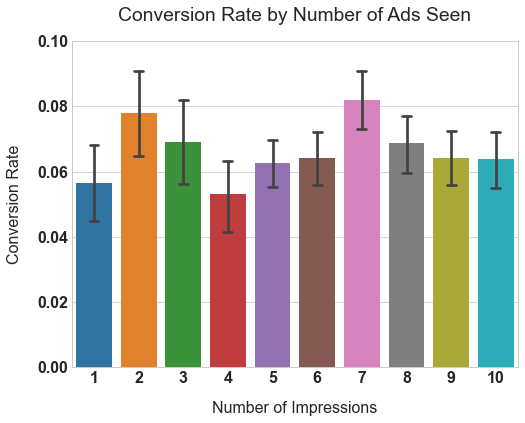

In [148]:
plt.figure(figsize=(8, 6))

sns.barplot(data=ads, x='impressions_per_visit', y='converted',
            estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Number of Ads Seen', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)
plt.ylim([0.0, 0.10])


In [133]:
# psa_conversion_rates = psas.groupby('impressions_per_visit')['converted']
# psa_conversion_rates = psa_conversion_rates.agg([mean, std_p, se_p])
# psa_conversion_rates.columns = [
#     'conversion_rate', 'std_deviation', 'std_error']
# psa_conversion_rates.style.format('{:.3f}')


(0.0, 0.1)

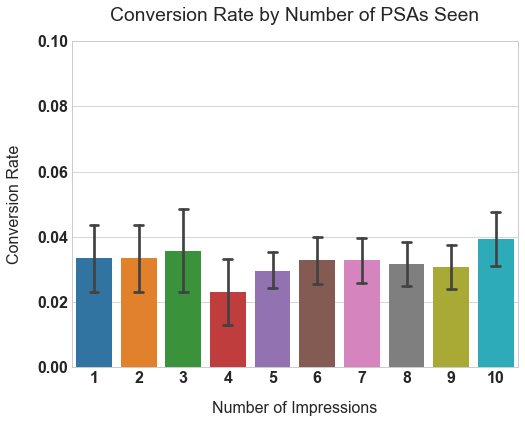

In [149]:
plt.figure(figsize=(8, 6))

sns.barplot(data=psas, x='impressions_per_visit', y='converted',
            estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Number of PSAs Seen', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)
plt.ylim([0.0, 0.10])


### Impressions by Hour

In [155]:
# psa_conversion_rates = ads.groupby('impressions_by_time')['converted']
# psa_conversion_rates = psa_conversion_rates.agg([mean, std_p, se_p])
# psa_conversion_rates.columns = [
#     'conversion_rate', 'std_deviation', 'std_error']
# psa_conversion_rates.style.format('{:.3f}')


Text(0, 0.5, 'Number of Impressions')

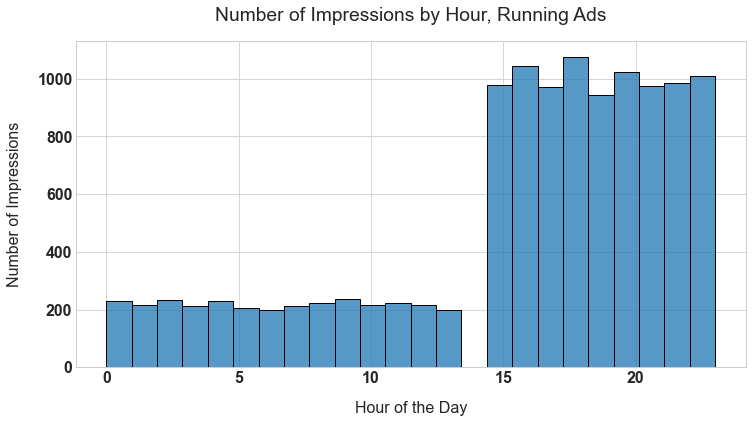

In [167]:
plt.figure(figsize=(12, 6))

sns.histplot(data=ads['impressions_by_time'], bins=24)
plt.title('Number of Impressions by Hour, Running Ads', pad=20)
plt.xlabel('Hour of the Day', labelpad=15)
plt.ylabel('Number of Impressions', labelpad=15)



Text(0, 0.5, 'Number of Conversions')

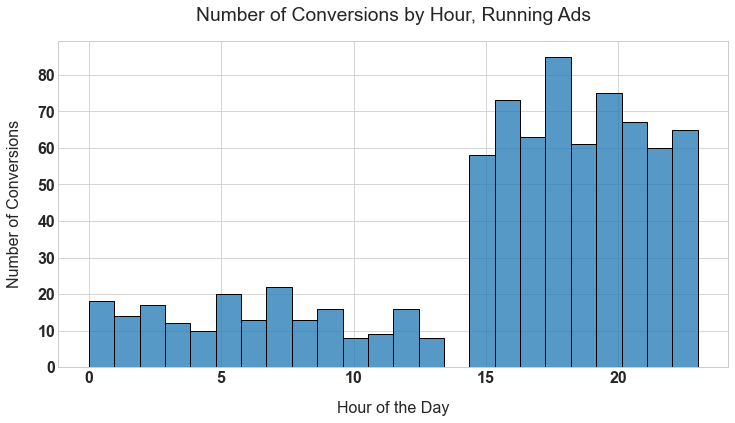

In [166]:
plt.figure(figsize=(12, 6))

sns.histplot(data=ads_converted['impressions_by_time'], bins=24)
plt.title('Number of Conversions by Hour, Running Ads', pad=20)
plt.xlabel('Hour of the Day', labelpad=15)
plt.ylabel('Number of Conversions', labelpad=15)


(0.0, 0.14)

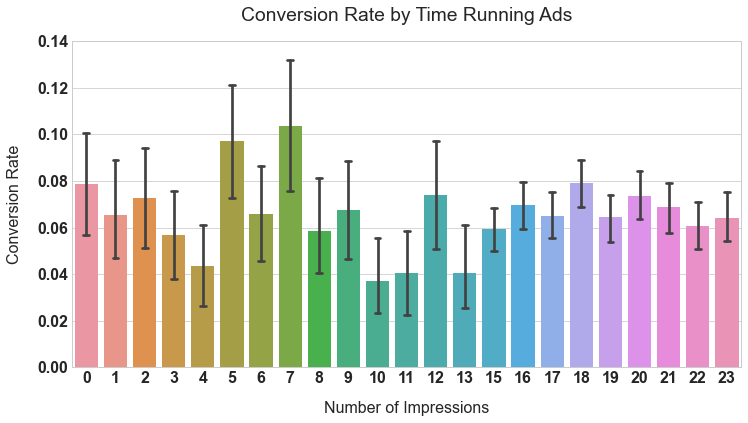

In [152]:
plt.figure(figsize=(12, 6))

sns.barplot(data=ads, x='impressions_by_time', y='converted',
            estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Time Running Ads', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)
plt.ylim([0.0, 0.14])


In [145]:
# psa_conversion_rates = psas.groupby('impressions_by_time')['converted']
# psa_conversion_rates = psa_conversion_rates.agg([mean, std_p, se_p])
# psa_conversion_rates.columns = [
#     'conversion_rate', 'std_deviation', 'std_error']
# psa_conversion_rates.style.format('{:.3f}')


(0.0, 0.14)

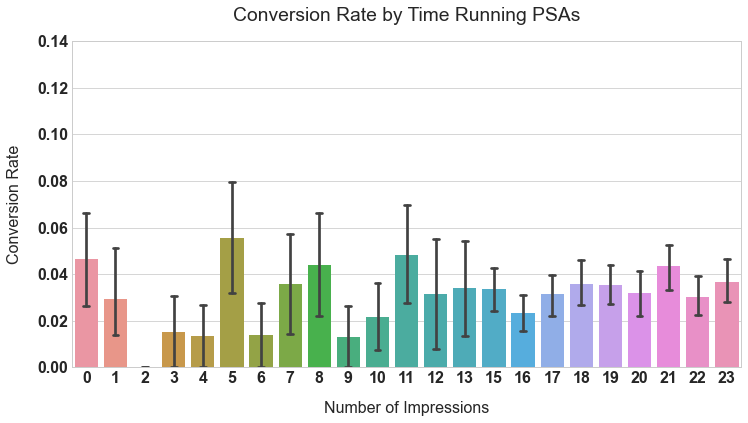

In [154]:
plt.figure(figsize=(12, 6))

sns.barplot(data=psas, x='impressions_by_time', y='converted',
            estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Time Running PSAs', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)
plt.ylim([0.0, 0.14])


### Day of the Month

In [137]:
# ad_conversion_rates = ads.groupby('impressions_by_date')['converted']
# ad_conversion_rates = ad_conversion_rates.agg([mean, std_p, se_p])
# ad_conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
# ad_conversion_rates.style.format('{:.3f}')


(0.0, 0.12)

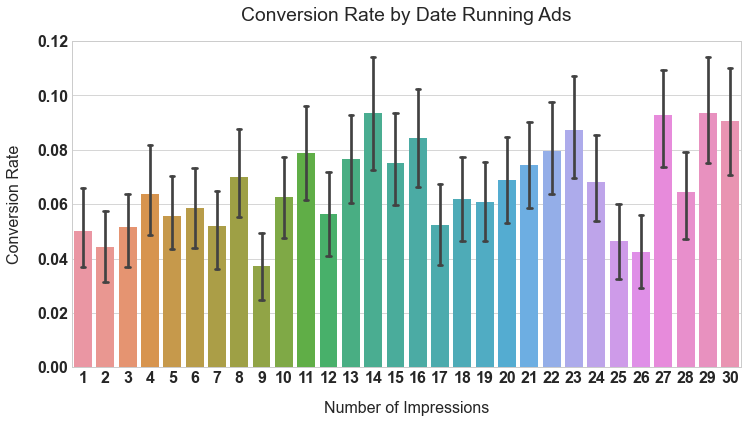

In [150]:
plt.figure(figsize=(12, 6))

sns.barplot(data=ads, x='impressions_by_date', y='converted',
            estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Date Running Ads', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)
plt.ylim([0.0, 0.12])


In [140]:
# psa_conversion_rates = psas.groupby('impressions_by_date')['converted']
# psa_conversion_rates = psa_conversion_rates.agg([mean, std_p, se_p])
# psa_conversion_rates.columns = [
#     'conversion_rate', 'std_deviation', 'std_error']
# psa_conversion_rates.style.format('{:.3f}')


(0.0, 0.12)

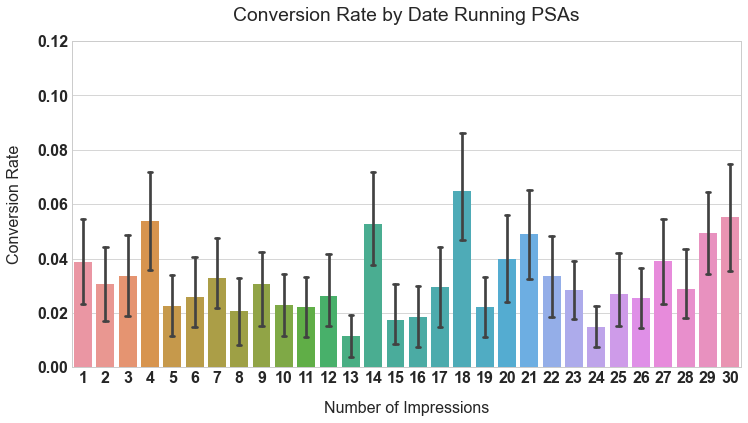

In [151]:
plt.figure(figsize=(12, 6))

sns.barplot(data=psas, x='impressions_by_date', y='converted',
            estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Date Running PSAs', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)
plt.ylim([0.0, 0.12])


## Analysis of Variance on the Ad Campaign
While we can analyze all of the differences between the PSA groups and the Ad groups, this will only take time and provide little actionable insight as to when to push the ads. In order to look at what 